## Step 1: Validate the files

This data set is provided by Kaggle as part of the `Titanic: Machine Learning from Disaster!` challenge.
I have already downloaded the data, and it can be found in the `./kaggle/input/titanic` dir associated with this notebook.

In [341]:
import os

kaggle_input_dir = "kaggle/input/titanic/"
if not os.path.exists(kaggle_input_dir):
    os.makedirs(kaggle_input_dir)

In [342]:
[f"{kaggle_input_dir}{file}" for file in os.listdir(kaggle_input_dir)]

['kaggle/input/titanic/gender_submission.csv',
 'kaggle/input/titanic/train.csv',
 'kaggle/input/titanic/test.csv',
 'kaggle/input/titanic/xgboost']

## Step 2: Explore the data

Let's first import some of the packages we'll need, then we can explore our data sets.

In [343]:
import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn.model_selection

In [344]:
train = pd.read_csv(os.path.join(kaggle_input_dir, 'train.csv'))
test = pd.read_csv(os.path.join(kaggle_input_dir, 'test.csv'))

In [345]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [346]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


We can already see that the data is organized very well, and there are some obvious features we can work with, such as `Age`, `Sex`, and `Pclass` (ticket class), `sibsp` (# of siblings / spouses aboard the Titanic), and `parch` (# of parents / children aboard the Titanic).

Other features like `Name`, might prove to be less important.

We also see our `Classifier` labeled here as `Survived`. This is obviously missing from the test set.

We can aso engineer some new features from this data, for instance; We can create a `child` feature based on age, as well as an `senior` feature.

## Step 3: Visualize the data

Since we have some theories about the data, we can visualize the data to get a better idea of which features are really correlated to survival. Let's start with `Pclass`

In [347]:
pclass_np = train[["Survived", "Pclass"]].values
survivors_pclass = pclass_np[pclass_np[:,0] == 1,:][:,1]
non_survivors_pclass = pclass_np[pclass_np[:,0] == 0,:][:,1]
print(non_survivors_pclass[:10])

[3 3 3 1 3 3 3 3 3 3]


(array([136.,  87., 119.]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)

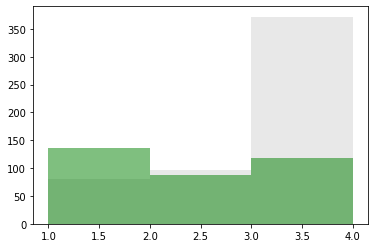

In [348]:
pclass_bins = range(1, 5)
plt.hist(non_survivors_pclass, bins=pclass_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_pclass, bins=pclass_bins, color="green", alpha=0.5)

We can see that our hunch was correct regarding `Pclass`, 3rd class passengers are much more likely not to survive, while 1st class passengers are the most likely to survive.

Let's look at `Age`, `Sex`, `SibSp`, and `Parch` next.

In [349]:
age_np = train[["Survived", "Age"]].values
survivors_age = age_np[age_np[:,0] == 1,:][:,1]
non_survivors_age = age_np[age_np[:,0] == 0,:][:,1]
# remove NaN
survivors_age = survivors_age[~np.isnan(survivors_age)]
non_survivors_age = non_survivors_age[~np.isnan(non_survivors_age)]
print(non_survivors_age[:10])

[22. 35. 54.  2. 20. 39. 14.  2. 31. 35.]


(array([20.,  9.,  4., 15., 27., 36., 30., 36., 34., 17., 12., 12., 14.,
         7.,  5.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
        69, 73, 77, 81, 85, 89, 93, 97]),
 <a list of 24 Patch objects>)

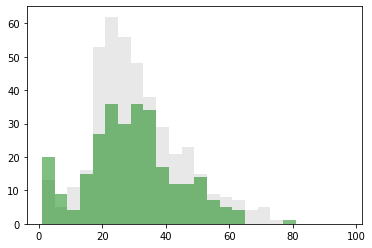

In [350]:
age_bins = range(1, 100, 4)
plt.hist(non_survivors_age, bins=age_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_age, bins=age_bins, color="green", alpha=0.5)

Again we find something interesting, while most age groups have proportional mortality rates to number of passengers, young children have significantly *higher* survival rates, while certain older groups have significantly *higher* mortality rates. So `Senior` and `Child` might prove to be good features to engineer.

In [351]:
sex_np = train[["Survived", "Sex"]].values
survivors_sex = sex_np[sex_np[:,0] == 1,:][:,1]
non_survivors_sex = sex_np[sex_np[:,0] == 0,:][:,1]
print(non_survivors_sex[:10])

['male' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'female']


(array([109.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 233.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

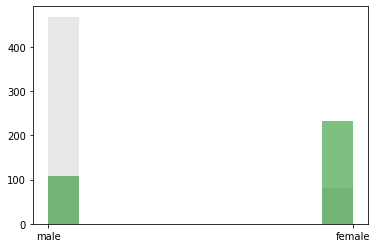

In [352]:
plt.hist(non_survivors_sex, color="lightgrey", alpha=0.5)
plt.hist(survivors_sex, color="green", alpha=0.5)

Again we see a trend, males are likely to not survive, while females are likely to survive.

In [353]:
sibsp_np = train[["Survived", "SibSp"]].values
survivors_sibsp = sibsp_np[sibsp_np[:,0] == 1,:][:,1]
non_survivors_sibsp = sibsp_np[sibsp_np[:,0] == 0,:][:,1]
print(non_survivors_sibsp[:10])

[1 0 0 0 3 0 1 0 4 1]


(array([112.,  13.,   4.,   3.,   0.,   0.,   0.,   0.]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

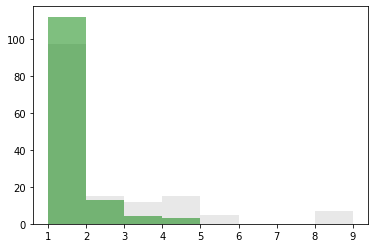

In [354]:
sibsp_bins = range(1, 10)
plt.hist(non_survivors_sibsp, bins=sibsp_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_sibsp, bins=sibsp_bins, color="green", alpha=0.5)

We find a similar story for `SibSp`, a higher `SibSp` indicates a higher mortality rate.

In [355]:
parch_np = train[["Survived", "Parch"]].values
survivors_parch = parch_np[parch_np[:,0] == 1,:][:,1]
non_survivors_parch = parch_np[parch_np[:,0] == 0,:][:,1]
print(non_survivors_parch[:10])

[0 0 0 0 1 0 5 0 1 0]


(array([65., 40.,  3.,  0.,  1.,  0.]),
 array([1, 2, 3, 4, 5, 6, 7]),
 <a list of 6 Patch objects>)

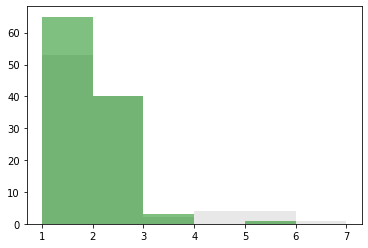

In [356]:
parch_bins = range(1, 8)
plt.hist(non_survivors_parch, bins=parch_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_parch, bins=parch_bins, color="green", alpha=0.5)

While less significant than the previous relations, we do see a relationship between high `Parch` and mortality.

In [357]:
embarked_np = train[["Survived", "Embarked"]].values
survivors_embarked = embarked_np[embarked_np[:,0] == 1,:][:,1].astype(str)
non_survivors_embarked = embarked_np[embarked_np[:,0] == 0,:][:,1].astype(str)
# remove NaN
survivors_embarked = survivors_embarked[survivors_embarked != 'nan']
non_survivors_embarked = non_survivors_embarked[non_survivors_embarked != 'nan']
print(non_survivors_embarked[:10])

['S' 'S' 'Q' 'S' 'S' 'S' 'S' 'S' 'Q' 'S']


(array([217.,   0.,   0.,   0.,   0.,  30.,   0.,   0.,   0.,  93.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

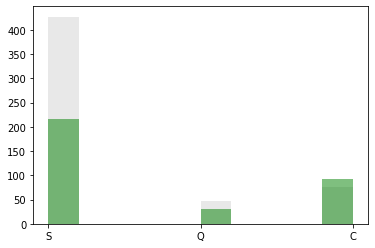

In [358]:
plt.hist(non_survivors_embarked, color="lightgrey", alpha=0.5)
plt.hist(survivors_embarked, color="green", alpha=0.5)

Although we didn't initial think `Embarked` would prove valuable, we do see some correlation here, though it may not be important.

In [359]:
fare_np = train[["Survived", "Fare"]].values
survivors_fare = fare_np[fare_np[:,0] == 1,:][:,1]
non_survivors_fare = fare_np[fare_np[:,0] == 0,:][:,1]
print(non_survivors_fare[:10])
print(survivors_fare.max())

[ 7.25    8.05    8.4583 51.8625 21.075   8.05   31.275   7.8542 29.125
 18.    ]
512.3292


(array([75., 71., 64., 18.,  4., 27.,  6., 19., 14.,  4.,  5.,  6.,  0.,
         6.,  2.,  4.,  2.,  0.,  0.,  0.,  0.,  3.,  3.,  0.,  1.,  0.,
         4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,
         0.,  0.]),
 array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
        131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
        261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
        391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511,
        521, 531, 541]),
 <a list of 54 Patch objects>)

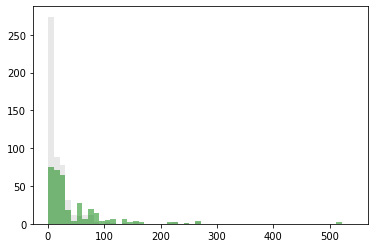

In [360]:
fare_bins = range(1, 550, 10)
plt.hist(non_survivors_fare, bins=fare_bins, color="lightgrey", alpha=0.5)
plt.hist(survivors_fare, bins=fare_bins, color="green", alpha=0.5)

We clearly see some correlation for `Fare`, though this might already be reflected in `Pclass`. We can experiment with this feature.

## Step 4: Algorithm choice and benchmark

With the above features in mind, an binary logistic XGBoost model might fit this problem well, we need a model that can perform well even on a limited feature set and with a moderte sample size. The model also needs to support binary classification, XGBoost should make for a fine choice.

Of course, we still need a benchmark to base our models performance on, we will aim for a relatively high accuracy (calculated by Kaggle) of about 80%.

## Step 5: Preprocessing the data

We've seen that our data can use some cleaning in order to "fix" missing data. Where possible, we will replace data using averages to avoid dropping rows. Let's start by looking at our data again.

In [361]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Let's go ahead and get rid of the features we've not selected for use in our model.

In [362]:
def get_df_with_base_features(df, selected_features):
    '''Returns a given DataFrame with only it's selected features.
       :param df: A dataframe
       :param selected_features: An array of selected features that correspond to certain columns in `df`
       :return: DataFrame: features_df'''
    
    features_df = df[selected_features]
    return features_df

In [363]:
selected_test_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
selected_train_features = ["Survived"] + selected_test_features

In [364]:
test_base_features_df = get_df_with_base_features(test, selected_test_features)
train_base_features_df = get_df_with_base_features(train, selected_train_features)

In [365]:
train_base_features_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [366]:
test_base_features_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Now that we have our feature data frames, we can normalize our data.

In [367]:
from sklearn.preprocessing import MinMaxScaler

def process_features(df, selected_features):
    '''Returns a given DataFrame with processed features.
       :param df: A dataframe
       :param selected_features: An array of selected features that correspond to certain columns in `df`
       :return: DataFrame: processed_df'''
    
    embarked_dict = {
        "C": 1,
        "Q": 2,
        "S": 3
    }
    
    sex_dict = {
        "female": 1,
        "male": 2
    }
    
    processed_df = df.copy()
    
    if 'Embarked' in processed_df.columns:
        # Replace nan with S, the most frequent and normal Embarked value
        processed_df.replace(np.nan, "S")
        processed_df["Embarked"] = processed_df["Embarked"].map(embarked_dict)

    if 'Sex' in processed_df.columns:
        processed_df["Sex"] = processed_df["Sex"].map(sex_dict)

    # Finally we scale the numeric columns
    scaler = MinMaxScaler()
    processed_df = pd.DataFrame(scaler.fit_transform(processed_df.astype(float)))
    processed_df.columns = df.columns
    processed_df.index = df.index

    return processed_df



In [368]:
processed_test_df = process_features(test_base_features_df, selected_test_features)
processed_train_df = process_features(train_base_features_df, selected_train_features)

In [369]:
processed_test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,1.0


In [370]:
processed_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.014151,1.0
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469,1.0
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.103644,1.0
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.015713,1.0


With that, we have our selected features, processed for our model.

## Step 6: Implementing the model

Now that we have our features, it's time to implement our model!
Let's begin by uploading our data, we'll also build a validation set from our train set.

In [371]:
model_data_dir = kaggle_input_dir + "xgboost/"

if not os.path.exists(model_data_dir):
    os.makedirs(model_data_dir)

In [426]:
from sklearn.model_selection import train_test_split
complete_test_df = processed_test_df.copy()
# split train into train and val
complete_train_df, complete_val_df = train_test_split(processed_train_df, test_size=0.33)

In [373]:
complete_test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,1.0


In [374]:
complete_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
874,1.0,0.5,0.0,0.346569,0.125,0.0,0.046845,0.0
202,0.0,1.0,1.0,0.421965,0.000,0.0,0.012679,1.0
740,1.0,0.0,1.0,NaN,0.000,0.0,0.058556,1.0
18,0.0,1.0,0.0,0.384267,0.125,0.0,0.035134,1.0
336,0.0,0.0,1.0,0.359135,0.125,0.0,0.129995,1.0


In [375]:
complete_val_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
596,1.0,0.5,0.0,NaN,0.000,0.0,0.064412,1.0
316,1.0,0.5,0.0,0.296306,0.125,0.0,0.050749,1.0
303,1.0,0.5,0.0,NaN,0.000,0.0,0.024106,0.5
270,0.0,0.0,1.0,NaN,0.000,0.0,0.060508,1.0
11,1.0,0.0,0.0,0.723549,0.000,0.0,0.051822,1.0


In [376]:
complete_train_df.to_csv(os.path.join(model_data_dir, "train.csv"), header=False, index=False)

complete_val_df.to_csv(os.path.join(model_data_dir, "validation.csv"), header=False, index=False)
complete_val_df[selected_test_features].to_csv(os.path.join(model_data_dir, "validation_x.csv"), header=False, index=False)

complete_test_df.to_csv(os.path.join(model_data_dir, "test.csv"), header=False, index=False)

Now we can upload our data s3.

In [377]:
import sagemaker

session = sagemaker.Session()

prefix = "kaggle-titanic-xgboost"

test_location = session.upload_data(os.path.join(model_data_dir, "test.csv"), key_prefix=prefix)
val_location = session.upload_data(os.path.join(model_data_dir, "validation.csv"), key_prefix=prefix)
val_x_location = session.upload_data(os.path.join(model_data_dir, "validation_x.csv"), key_prefix=prefix)
train_location = session.upload_data(os.path.join(model_data_dir, "train.csv"), key_prefix=prefix)

Finally, we can start constructing our XGBoost model!

In [378]:
from sagemaker import get_execution_role

role = get_execution_role()

In [379]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, "xgboost")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [441]:
xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type="ml.m4.xlarge",
                                    output_path="s3://{}/{}/output".format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=8,
                        eta=0.4461468909040185,
                        gamma=0.0019526615254589956,
                        min_child_weight=3,
                        subsample=0.8225794003726403,
                        silent=0,
                        objective="binary:logistic",
                        early_stopping_rounds=20,
                        num_round=500)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


We can take advantage of SageMakers `HyperparameterTuner` to optimize our model automatically.

In [455]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb,
                                               #objective_metric_name = "validation:rmse", reulted in accuracy of 0.7830508474576271
                                               objective_metric_name = "validation:error", # resulted in an accuracy of 0.8203389830508474
                                               objective_type = "Minimize",
                                               #max_jobs = 20, in test, the model stopped improving after 7 or 8 jobs
                                               max_jobs = 20,
                                               max_parallel_jobs = 3,
                                               hyperparameter_ranges = {
                                                    #"max_depth": IntegerParameter(3, 12), in test, higher depth performed better, so we'll try with higher values
                                                    "max_depth": IntegerParameter(3, 15),
                                                    "eta"      : ContinuousParameter(0.05, 0.5),
                                                    #"min_child_weight": IntegerParameter(2, 8), in test, higher min child weight performed better, so we'll asjust this one
                                                    "min_child_weight": IntegerParameter(2, 12),
                                                    "subsample": ContinuousParameter(0.5, 0.9),
                                                    "gamma": ContinuousParameter(0, 10)
                                               })

In [456]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [383]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [384]:
xgb_hyperparameter_tuner.wait()

.....................................................................................................................................................................................................................!


Now that our model is trained, we can take our best training job and attach it and create our transformer.

In [385]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-20 13:15:37 Starting - Preparing the instances for training
2020-08-20 13:15:37 Downloading - Downloading input data
2020-08-20 13:15:37 Training - Training image download completed. Training in progress.
2020-08-20 13:15:37 Uploading - Uploading generated training model
2020-08-20 13:15:37 Completed - Training job completedArguments: train
[2020-08-20:13:15:25:INFO] Running standalone xgboost training.
[2020-08-20:13:15:25:INFO] Setting up HPO optimized metric to be : error
[2020-08-20:13:15:25:INFO] File size need to be processed in the node: 0.05mb. Available memory size in the node: 8474.36mb
[2020-08-20:13:15:25:INFO] Determined delimiter of CSV input is ','
[13:15:25] S3DistributionType set as FullyReplicated
[13:15:25] 596x7 matrix with 4172 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-20:13:15:26:INFO] Determined delimiter of CSV input is ','
[13:15:25] S3DistributionType set as FullyReplicated
[13:15:26] 295x7 matrix with 

In [386]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Let's see how our model performs on our validation test data.

In [387]:
xgb_transformer.transform(val_x_location, content_type='text/csv', split_type='Line')

In [388]:
xgb_transformer.wait()

..............................
2020-08-20T13:20:57.770:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-08-20 13:20:57 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-20 13:20:57 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-20 13:20:57 +0000] [1] [INFO] Using worker: gevent
[2020-08-20 13:20:57 +0000] [37] [INFO] Booting worker with pid: 37
[2020-08-20 13:20:57 +0000] [38] [INFO] Booting worker with pid: 38
[2020-08-20 13:20:57 +0000] [39] [INFO] Booting worker with pid: 39
[2020-08-20:13:20:57:INFO] Model loaded successfully for worker : 38
[2020-08-20:13:20:57:INFO] Model loaded successfully for worker : 37
[2020-08-20:13:20:57:INFO] Model loaded successfully for worker : 39
[2020-08-20:13:20:57:INFO] Sniff delimiter as ','
[2020-08-20:13:20:57:INFO] Determined delimiter of CSV input is ','
Arguments: serve
[2020-08-20 13:20:57 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-20 13:20:57 +0000]

Let's get our predictions.

In [389]:
!aws s3 cp --recursive $xgb_transformer.output_path $model_data_dir

download: s3://sagemaker-us-east-2-984881703516/xgboost-200820-1258-010-fd30338f-2020-08-20-13-16-10-205/validation_x.csv.out to kaggle/input/titanic/xgboost/validation_x.csv.out


Now we can assess the accuracy of our predictions.

In [390]:
from sklearn.metrics import accuracy_score

complete_val_y = complete_val_df["Survived"].squeeze().values
predictions = pd.read_csv(os.path.join(model_data_dir, 'validation_x.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

accuracy_score(complete_val_y, predictions)

0.8576271186440678

## Step 7: Refining the model

Now that we have a working model, we can work on improving it, we'll handle the refinement in the model above, but we can take some notes as we go.

#### Iteration 1
First of all, we can see that `validation:error` is a good metric to aim for, resulting in an improved accuracy when compared with rmse.

#### Iteration 2
Second, we found that the best models had higher `max_depth` and `min_child_weight`. So we can raise the values (min/max range) of these params in our tuning job. We will also go ahead and enter the best model params as defaults for our hyper params. At the end of this iteration we can note our "best performing" params
 
Leaving us with params:
                        
                        max_depth=8,
                        eta=0.4461468909040185,
                        gamma=0.0019526615254589956,
                        min_child_weight=3,
                        subsample=0.8225794003726403,
                      
And a final accuracy of 0.8576271186440678

This meets our goal of 80% accuracy!

## Step 8: Final refinement and feature engineering

Now that we have an effective model, let's see about engineering our two features `Child` and `Senior`.
We will classify a child as a passenger who is 12 years old or younger, likewise we will classify a senior as a passenger 55 years old or older.

In [457]:
def eng_features(df):
    '''Returns a given DataFrame with processed features.
       :param df: A dataframe
       :return: DataFrame: engineered_df'''
    
    # we convert the ages 55 and 12 to the proper processed values by referencing the xgboost/train.csv file
    senior_min_age = 0.49736114601658704
    child_max_age = 0.17064589092736868
    
    engineered_df = df.copy()
    # let's fill in the NaN ages 
    engineered_df["Age"] = engineered_df["Age"].fillna((engineered_df['Age'].mean())).values
    # now let's create our child and senior features
    engineered_df["Child"] = [float(age <= child_max_age) for age in engineered_df["Age"].squeeze().values]
    engineered_df["Senior"] = [float(age >= senior_min_age) for age in engineered_df["Age"].squeeze().values]

    return engineered_df

In [458]:
engineered_train_df = eng_features(complete_train_df)
engineered_val_df = eng_features(complete_val_df)
engineered_test_df = eng_features(complete_test_df)

engineered_train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Child,Senior
847,0.0,1.0,1.0,0.434531,0.000,0.000000,0.015412,0.0,0.0,0.0
211,1.0,0.5,0.0,0.434531,0.000,0.000000,0.040989,1.0,0.0,0.0
308,0.0,0.5,1.0,0.371701,0.125,0.000000,0.046845,0.0,0.0,0.0
46,0.0,1.0,1.0,0.360392,0.125,0.000000,0.030254,0.5,0.0,0.0
179,0.0,1.0,1.0,0.447097,0.000,0.000000,0.000000,1.0,0.0,0.0
131,0.0,1.0,1.0,0.246042,0.000,0.000000,0.013761,1.0,0.0,0.0
445,1.0,0.0,1.0,0.044986,0.000,0.333333,0.159777,1.0,1.0,0.0
682,0.0,1.0,1.0,0.246042,0.000,0.000000,0.018006,1.0,0.0,0.0
674,0.0,0.5,1.0,0.360392,0.000,0.000000,0.000000,1.0,0.0,0.0
644,1.0,1.0,0.0,0.004147,0.250,0.166667,0.037590,0.0,1.0,0.0


Now let's upload this new data.

In [459]:
eng_selected_test_features = selected_test_features + ["Child", "Senior"]

engineered_train_df.to_csv(os.path.join(model_data_dir, "eng_train.csv"), header=False, index=False)

engineered_val_df.to_csv(os.path.join(model_data_dir, "eng_validation.csv"), header=False, index=False)
engineered_val_df[eng_selected_test_features].to_csv(os.path.join(model_data_dir, "eng_validation_x.csv"), header=False, index=False)

engineered_test_df.to_csv(os.path.join(model_data_dir, "eng_test.csv"), header=False, index=False)

In [460]:
eng_test_location = session.upload_data(os.path.join(model_data_dir, "eng_test.csv"), key_prefix=prefix)
eng_val_location = session.upload_data(os.path.join(model_data_dir, "eng_validation.csv"), key_prefix=prefix)
eng_val_x_location = session.upload_data(os.path.join(model_data_dir, "eng_validation_x.csv"), key_prefix=prefix)
eng_train_location = session.upload_data(os.path.join(model_data_dir, "eng_train.csv"), key_prefix=prefix)

And finally we can do another round of training training

In [461]:
s3_eng_input_train = sagemaker.s3_input(s3_data=eng_train_location, content_type='csv')
s3_eng_input_validation = sagemaker.s3_input(s3_data=eng_val_location, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [462]:
xgb_hyperparameter_tuner.fit({'train': s3_eng_input_train, 'validation': s3_eng_input_validation})

In [463]:
xgb_hyperparameter_tuner.wait()

................................................................................................................................................................................................................................................................................!


In [464]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-20 15:33:12 Starting - Preparing the instances for training
2020-08-20 15:33:12 Downloading - Downloading input data
2020-08-20 15:33:12 Training - Training image download completed. Training in progress.
2020-08-20 15:33:12 Uploading - Uploading generated training model
2020-08-20 15:33:12 Completed - Training job completedArguments: train
[2020-08-20:15:33:00:INFO] Running standalone xgboost training.
[2020-08-20:15:33:00:INFO] Setting up HPO optimized metric to be : error
[2020-08-20:15:33:00:INFO] File size need to be processed in the node: 0.06mb. Available memory size in the node: 8493.48mb
[2020-08-20:15:33:00:INFO] Determined delimiter of CSV input is ','
[15:33:00] S3DistributionType set as FullyReplicated
[15:33:00] 596x9 matrix with 5364 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-20:15:33:00:INFO] Determined delimiter of CSV input is ','
[15:33:00] S3DistributionType set as FullyReplicated
[15:33:00] 295x9 matrix with 

In [465]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [466]:
xgb_transformer.transform(eng_val_x_location, content_type='text/csv', split_type='Line')

In [467]:
xgb_transformer.wait()

...........................
.2020-08-20T15:50:39.635:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-08-20 15:50:39 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-20 15:50:39 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-20 15:50:39 +0000] [1] [INFO] Using worker: gevent
[2020-08-20 15:50:39 +0000] [38] [INFO] Booting worker with pid: 38
[2020-08-20 15:50:39 +0000] [39] [INFO] Booting worker with pid: 39
[2020-08-20 15:50:39 +0000] [40] [INFO] Booting worker with pid: 40
[2020-08-20 15:50:39 +0000] [41] [INFO] Booting worker with pid: 41
[2020-08-20:15:50:39:INFO] Model loaded successfully for worker : 38
[2020-08-20:15:50:39:INFO] Model loaded successfully for worker : 39
[2020-08-20:15:50:39:INFO] Model loaded successfully for worker : 40
[2020-08-20:15:50:39:INFO] Sniff delimiter as ','
Arguments: serve
[2020-08-20 15:50:39 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-20 15:50:39 +0000] [

In [468]:
!aws s3 cp --recursive $xgb_transformer.output_path $model_data_dir

download: s3://sagemaker-us-east-2-984881703516/xgboost-200820-1523-009-cab915ac-2020-08-20-15-46-12-130/eng_validation_x.csv.out to kaggle/input/titanic/xgboost/eng_validation_x.csv.out


In [472]:
eng_val_y = engineered_val_df["Survived"].squeeze().values
eng_predictions = pd.read_csv(os.path.join(model_data_dir, 'eng_validation_x.csv.out'), header=None)
eng_predictions = [round(num) for num in eng_predictions.squeeze().values]

accuracy_score(eng_val_y, eng_predictions)

0.8508474576271187

## Step 9: Evaluate and Validate the model

Above, we have our trained predictor, now we can use it to predict our test data, finally we will format the test data as a csv and submit it.

In [473]:
xgb_transformer.transform(eng_test_location, content_type='text/csv', split_type='Line')

In [474]:
xgb_transformer.wait()

..............................
2020-08-20T16:01:58.514:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-08-20 16:01:58 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-20 16:01:58 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-20 16:01:58 +0000] [1] [INFO] Using worker: gevent
Arguments: serve
[2020-08-20 16:01:58 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-20 16:01:58 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-20 16:01:58 +0000] [1] [INFO] Using worker: gevent
[2020-08-20 16:01:58 +0000] [37] [INFO] Booting worker with pid: 37
[2020-08-20:16:01:58:INFO] Model loaded successfully for worker : 37
[2020-08-20 16:01:58 +0000] [38] [INFO] Booting worker with pid: 38
[2020-08-20:16:01:58:INFO] Sniff delimiter as ','
[2020-08-20:16:01:58:INFO] Determined delimiter of CSV input is ','
[2020-08-20:16:01:58:INFO] Model loaded successfully for worker : 38
[2020-08-20 16:01:58 +0000]

In [475]:
!aws s3 cp --recursive $xgb_transformer.output_path $model_data_dir

download: s3://sagemaker-us-east-2-984881703516/xgboost-200820-1523-009-cab915ac-2020-08-20-15-57-10-692/eng_test.csv.out to kaggle/input/titanic/xgboost/eng_test.csv.out


In [489]:
test_predictions = pd.read_csv(os.path.join(model_data_dir, "eng_test.csv.out"), header=None)
test_predictions = [int(round(num)) for num in test_predictions.squeeze().values]
test_prediction_df = pd.concat([test, pd.DataFrame(data=test_predictions, columns=["Survived"])], axis=1)

Let's preview our predictions!

In [490]:
test_prediction_df.head(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0


Looks good! This is about what we'd expect.

Looking at passenger 904, a young woman of `Pclass` 1, we see that she is predicted as a survivor. This matches our initial expectations.

Likewise passenger 905, an older man of `Pclass` 2, was not predicted to survive.



To submit our predictions we only need two columns, `PassengerId` and `Survived`. So let's get that below.

In [491]:
submission_df = test_prediction_df[["PassengerId", "Survived"]]
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Finally we can create our submission with the cell below

In [492]:
submission_df.to_csv(os.path.join(model_data_dir, "submission.csv"), index=False)